In [22]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

## Data Preparation

In [3]:
# load File
base_df = pd.read_csv('Nat_Gas.csv')
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [14]:
# Preserve original loaded dataset through copy
clean_df = base_df.copy()

# Parse date column from object to datetime
clean_df['Dates'] = pd.to_datetime(clean_df['Dates'], format='%m/%d/%y')

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


c:\Users\JohnJoemmelRodelas\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


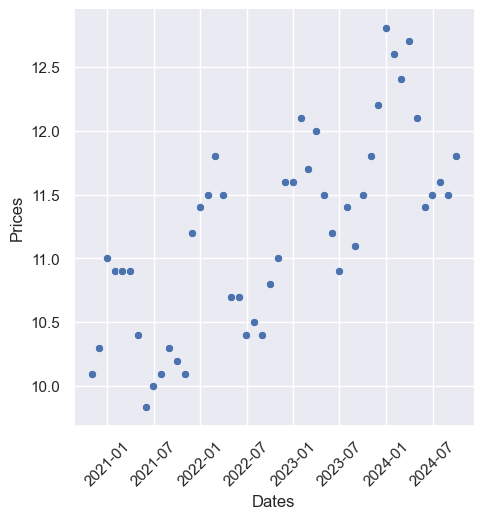

In [30]:
# Visualize data using seaborn
scatter = sns.relplot(data=clean_df, x='Dates', y='Prices')
scatter.tick_params(axis='x', labelrotation=45)

## Model Building